#### 모델 결과물 확인용
- 훈련하는 중간에 저장된 가중치에 대해 test 데이터를 아무 때나 넣어보고 확인할 수 있다

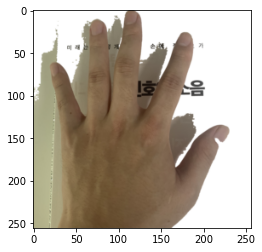

In [103]:
import Training_utils, torchvision
from torchvision import transforms
import tb_utils
from tb_utils import *
from Training_utils import *
from Image_Process_utils import *
import model_utils
from model_utils import *
from Dataset_utils import *
import arg_parser
from arg_parser import common_arg_parser
from torch.utils.data import ConcatDataset

my_transforms = transforms.Compose([
    #transforms.Normalize((0.5,), (0.5,)),
    Rescale(256),
    Tensorize()
    ])

# for creating test image list
test_imlist, target_imlist =  gen_test_img_list()
np_img = np.transpose( to_numpy(test_imlist[0]), (1,2,0))
plt.imshow(np_img)

In [104]:
arg_parser =common_arg_parser()
args, unknown_args = arg_parser.parse_known_args()

In [105]:
model_name = 'resnet34' # 
model = create_model(model_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device) # cuda:0 뜨면 gpu 
model.to(device) # model gpu 로 바꿔주자 

best_val = 100000000
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.5, 0.999))
scheduler = StepLR(optimizer, step_size = 1, gamma = 0.9)
class_loss = class_loss()
coord_loss = coord_loss()

device:  cuda:0


In [106]:
# checkpoint 폴더에 있는 파일명을 넣으면 해당 지점부터 train 다시 시작함

args.resume = './checkpoints/urjae0830_2323all+sc+sc_filled_model_best.pth.tar'

if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_val = checkpoint['best_val']
        model.load_state_dict(checkpoint['state_dict'])
        if 'optimizer' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

=> loading checkpoint './checkpoints/urjae0830_2323all+sc+sc_filled_model_best.pth.tar'
=> loaded checkpoint './checkpoints/urjae0830_2323all+sc+sc_filled_model_best.pth.tar' (epoch 53)


142.09857 174.46556


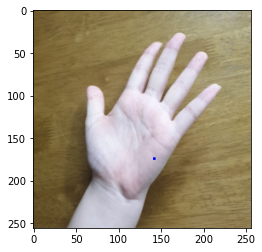

In [119]:
# testdata 폴더에 이미지 넣고 직접 테스트 해보는 것도 가능 
# 이때 모델이 훈련한 사이즈로 resize 해줘야 함 (기본:256)


# dorsal : 합곡, 중저, 액문, 소택, 소충, 관충, 중충, 상양
# palmar : 소부, 어제, 노궁, 소상, 태연, 대릉, 신문 


hand_pos = 'palmar'
#i = np.random.randint(low = 0, high = 14)
i = 10
dir1 = f'./testdata/{hand_pos}'
imdir_hand_list = os.listdir(dir1)
imdir_h = os.path.join(dir1, imdir_hand_list[i])
img = Image.open(imdir_h)
#img = img.rotate(-90)
transform = transforms.Compose([transforms.Resize(size = (256,256)),transforms.ToTensor()])
img = transform(img)
np_img = np.transpose( to_numpy(img), (1,2,0))

img2 = clear_background(cv2.imread(imdir_h))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img2)
img2 = transform(im_pil)

_, out2 = model(img2.unsqueeze(0).to('cuda'))
x,y = to_numpy(out2)[0]
print(x,y)
plt.imshow(create_circle_patch(np_img, x, y, color = 'blue'))